# Inference script

Da usare per:
- creare gli output video
- testare nuovi metodi di inferenza
- calcolare metrics di un modello salvato
- testare nuovi metodi per valutare le preds

Nel config file, modificare i parametri nella "testing" section

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import logging
import os
import math
import time

import numpy as np
import torch
from datasets import SparkDataset
# import unet_openai
from torch import nn
# from torch.cuda.amp import GradScaler
from torch.utils.tensorboard import SummaryWriter
from training_inference_tools import get_preds, myTrainingManager
from data_processing_tools import get_event_instances_class, get_processed_result
from in_out_tools import write_videos_on_disk
from training_script_utils import init_param_config_logs, init_model

import unet

logger = logging.getLogger(__name__)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [2]:
################################ Set parameters ################################

params = {}

training_name = "final_model"
config_file = "config_final_model.ini"
use_train_data = False
get_final_pred = True # set to False to only compute raw predictions
testing = False  # set to False to only generate unet predictions
                # set to True to also compute processed outputs and metrics
# inference_types = ['overlap', 'average', 'gaussian', 'max']
inference_types = None # set to None to use the default inference type from
                        # the config file

if testing:
    get_final_pred = True

In [3]:
if get_final_pred:
    # set physiological and validation parameters

    # physiological params (for spark peaks results)
    pixel_size = 0.2  # 1 pixel = 0.2 um x 0.2 um
    # min distance in space
    min_dist_xy = round(1.8 / pixel_size) # = 9 pixels
    time_frame = 6.8  # 1 frame = 6.8 ms
    # min distance in time
    min_dist_t = round(20 / time_frame)  # = 3 frames

    # spark instances detection parameters
    radius = math.ceil(min_dist_xy / 2)
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    disk = x**2 + y**2 <= radius**2
    conn_mask = np.stack([disk] * (min_dist_t), axis=0)

    debug = True
    ca_release_events = ['sparks', 'puffs', 'waves']

    # TODO: use better parameters !!!
    pixel_size = 0.2
    spark_min_width = 3
    spark_min_t = 3
    puff_min_t = 5
    wave_min_width = round(15 / pixel_size)

    # connectivity for event instances detection
    connectivity = 26

    # maximal gap between two predicted puffs or waves that belong together
    max_gap = 2  # i.e., 2 empty frames

    sigma = 3

    # parameters for correspondence computation
    # threshold for considering annotated and pred ROIs a match
    iomin_t = 0.5

In [4]:
############################## get parameters ##############################

c, params, wandb_log = init_param_config_logs(
    basedir=None,
    verbosity=3,
    #config_file="config_openai_unet.ini"
    config_file="config_final_model.ini",
    print_params=False
    )

[17:02:23] [  INFO  ] [training_script_utils] < 96 > -- Loading config_files\config_final_model.ini


In [5]:
logger.info(f"Processing training '{training_name}'...")

[17:02:23] [  INFO  ] [  __main__  ] < 1  > -- Processing training 'final_model'...


In [6]:
########################### Detect GPU, if available ###########################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()
logger.info(f"Using device '{device}' with {n_gpus} GPUs")


[17:02:23] [  INFO  ] [  __main__  ] < 5  > -- Using device 'cuda' with 1 GPUs


In [7]:
######################## Config dataset and UNet model #########################

### Configure dataset method ###
dataset_size = c.get("testing", "dataset_size")
dataset_inference = c.get("testing", "inference")

if use_train_data:
    logger.info("Predict outputs for training data")
    if dataset_size == "full":
        sample_ids = ["01", "02", "03", "04", "06", "07", "08", "09",
                      "11", "12", "13", "14", "16", "17", "18", "19",
                      "21", "22", "23", "24", "27", "28", "29", "30",
                      "33", "35", "36", "38", "39", "41", "42", "43",
                      "44", "46"]
    elif dataset_size == "minimal":
        sample_ids = ["01"]
else:
    logger.info("Predict outputs for testing data")
    if dataset_size == "full":
        sample_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]
    elif dataset_size == "minimal":
        sample_ids = ["34"]

relative_path = c.get("dataset", "relative_path")
dataset_path = os.path.realpath(f"{relative_path}")
assert os.path.isdir(dataset_path), f'"{dataset_path}" is not a directory'
logger.info(f"Using {dataset_path} as dataset root path")


[17:02:23] [  INFO  ] [  __main__  ] < 18 > -- Predict outputs for testing data
[17:02:23] [  INFO  ] [  __main__  ] < 27 > -- Using C:\Users\dotti\sparks_project\data\sparks_dataset as dataset root path


In [8]:
########################### Configure output folder ############################

output_folder = "trainings_validation" # same folder for train and test preds
os.makedirs(output_folder, exist_ok=True)

# subdirectory of output_folder where predictions are saved
# change this to save results for same model with different inference approaches
#output_name = training_name + "_step=2"
output_name = training_name

save_folder = os.path.join(output_folder, output_name)
os.makedirs(save_folder, exist_ok=True)
logger.info(f"Annotations and predictions will be saved on '{save_folder} + inference_type'")

[17:02:23] [  INFO  ] [  __main__  ] < 13 > -- Annotations and predictions will be saved on 'trainings_validation\final_model + inference_type'


In [9]:
### Configure UNet ###

assert params['nn_architecture'] in ['pablos_unet', 'github_unet', 'openai_unet'], \
    f"nn_architecture must be one of 'pablos_unet', 'github_unet', 'openai_unet'"

params['load_epoch'] = c.getint("testing", "load_epoch")
params['batch_size'] = c.getint("testing", "batch_size", fallback="1")

network = init_model(
    params=params,
    num_classes=4,
    ndims=3
    )
network = nn.DataParallel(network).to(device)
network.eval()

### Load UNet model ###
models_relative_path = "runs/"
model_path = os.path.join(models_relative_path, training_name)
# logger.info(f"Saved model path: {model_path}")
summary_writer = SummaryWriter(
    os.path.join(model_path, "summary"), purge_step=0
    )

trainer = myTrainingManager(
    # training items
    training_step=None,
    save_path=model_path,
    managed_objects=unet.managed_objects({"network": network}),
    summary_writer=summary_writer,
)

logger.info(
    f"Loading trained model '{training_name}' at epoch {params['load_epoch']}...")
trainer.load(params['load_epoch'])
# logger.info(f"Loaded trained model located in '{model_path}'")


[17:02:25] [  INFO  ] [  __main__  ] < 33 > -- Loading trained model 'final_model' at epoch 100000...
[17:02:25] [  INFO  ] [unet.trainer] <131 > -- Loading 'runs/final_model\network_100000.pth'...


In [11]:
############################# Run samples in UNet ##############################

xs = {}
ys = {}
ys_instances = {}
preds = {}
if get_final_pred:
    preds_instances = {}
    preds_segmentation = {}

for sample_id in sample_ids:
    logger.debug(f"Processing sample {sample_id}...")
    start = time.time()
    ### Create dataset ###
    testing_dataset = SparkDataset(
        base_path=dataset_path,
        sample_ids=[sample_id],
        testing=testing,
        smoothing=c.get("dataset", "data_smoothing"),
        step=c.getint("testing", "data_step"),
        duration=c.getint("testing", "data_duration"),
        remove_background=c.get("dataset", "remove_background"),
        temporal_reduction=c.getboolean(
            "network", "temporal_reduction", fallback=False
        ),
        num_channels=c.getint("network", "num_channels", fallback=1),
        normalize_video=c.get("dataset", "norm_video"),
        only_sparks=c.getboolean("dataset", "only_sparks", fallback=False),
        sparks_type=c.get("dataset", "sparks_type"),
        ignore_frames=c.get("training", "ignore_frames_loss"),
        ignore_index=4,
        gt_available=True,
        inference=dataset_inference,
    )

    logger.info(
        f"\tTesting dataset of movie {testing_dataset.video_name} "
        f"contains {len(testing_dataset)} samples."
    )

    logger.info(f"\tProcessing samples in UNet...")
    # ys and preds are numpy arrays
    xs[sample_id], ys[sample_id], preds[sample_id] = get_preds(
        network=network, 
        test_dataset=testing_dataset, 
        compute_loss=False, 
        device=device, 
        batch_size=c.getint("testing", "batch_size", fallback="1"),
        inference_types=inference_types,
    )

    if testing:
        # get labelled event instances, for validation
        # ys_instances is a dict with classified event instances, for each class
        ys_instances[sample_id] = get_event_instances_class(
            event_instances=testing_dataset.events, class_labels=ys[sample_id], shift_ids=True
        )
        # remove ignored events entry from ys_instances
        ys_instances[sample_id].pop("ignore", None)

        # get pixels labelled with 4
        # ignore_mask = np.where(ys == 4, 1, 0)

    if get_final_pred:
        
        ######################### get processed output #########################

        logger.debug(
            "Getting processed output (segmentation and instances)")

        # get predicted segmentation and event instances
        if inference_types is None or len(inference_types) == 1:
            preds_instances[sample_id], preds_segmentation[sample_id], _ = get_processed_result(
                sparks=preds[sample_id][1],
                puffs=preds[sample_id][3],
                waves=preds[sample_id][2],
                xs=xs[sample_id],
                conn_mask=conn_mask,
                connectivity=connectivity,
                max_gap=max_gap,
                sigma=sigma,
                wave_min_width=wave_min_width,
                puff_min_t=puff_min_t,
                spark_min_t=spark_min_t,
                spark_min_width=spark_min_width,
                training_mode=False,
                debug=debug
            )
        else:
            # initialize empty dicts what will be indexed by inference type
            preds_instances[sample_id], preds_segmentation[sample_id] = {}, {}
            
            for i in inference_types:
                logger.debug(f"\tProcessing inference type {i}...")
                preds_instances[sample_id][i], preds_segmentation[sample_id][i], _ = get_processed_result(
                    sparks=preds[sample_id][i][1],
                    puffs=preds[sample_id][i][3],
                    waves=preds[sample_id][i][2],
                    xs=xs[sample_id],
                    conn_mask=conn_mask,
                    connectivity=connectivity,
                    max_gap=max_gap,
                    sigma=sigma,
                    wave_min_width=wave_min_width,
                    puff_min_t=puff_min_t,
                    spark_min_t=spark_min_t,
                    spark_min_width=spark_min_width,
                    training_mode=False,
                    debug=debug
                )
        
    if not get_final_pred:
        logger.info(f"\tTime to process sample {sample_id} in UNet: {time.time() - start:.2f} seconds.")
    else:
        logger.info(f"\tTime to process sample {sample_id} in UNet + post-processing: {time.time() - start:.2f} seconds.")

    ### Save preds on disk ###
    logger.info(f"\tSaving annotations and predictions...")

    video_name = f"{str(params['load_epoch'])}_{testing_dataset.video_name}"

    if inference_types is None or len(inference_types) == 1:
        write_videos_on_disk(
            training_name=output_name,
            video_name=video_name,
            path=save_folder,
            preds=preds[sample_id],
            ys=ys[sample_id],
        )
    else:
        for i in inference_types:
            write_videos_on_disk(
                training_name=output_name,
                video_name=video_name,
                path=os.path.join(save_folder, "inference_"+i),
                preds=preds[sample_id][i],
                ys=ys[sample_id],
            )

logger.info(f"DONE")


[17:05:00] [ DEBUG  ] [  __main__  ] < 12 > -- Processing sample 05...
[17:05:00] [ DEBUG  ] [  datasets  ] <294 > -- Added padding of 12 frames to video with unsuitable duration
[17:05:00] [  INFO  ] [  __main__  ] < 36 > -- 	Testing dataset of movie 05 contains 9 samples.
[17:05:00] [  INFO  ] [  __main__  ] < 41 > -- 	Processing samples in UNet...
[17:05:02] [ DEBUG  ] [  __main__  ] < 68 > -- Getting processed output (segmentation and instances)
[17:05:02] [ DEBUG  ] [data_processing_tools] <459 > -- Events detection threshold: 0.498
[17:05:07] [ DEBUG  ] [data_processing_tools] <525 > -- Number of sparks detected by nonmaxima suppression: 130
[17:05:18] [ DEBUG  ] [data_processing_tools] <886 > -- Time for removing small events: 10.28 s
[17:05:18] [  INFO  ] [  __main__  ] <115 > -- 	Time to process sample 05 in UNet + post-processing: 18.67 seconds.
[17:05:18] [  INFO  ] [  __main__  ] <118 > -- 	Saving annotations and predictions...
[17:05:18] [ DEBUG  ] [in_out_tools] <278 > --

## Compute metrics

- if considering more than one inference type:
    - `preds_instances` is a nested dict indexed first by movie id, then by inference type, and finally by class. E.g., `preds_instances['05']['overlap']['sparks']` is a numpy array of shape (500, 64, 512) with integer values denoting the events' IDs.
    - `preds_segmentation` is a nested dict indexed first by movie id, then by inference type, and finally by class e.g., `preds_segmentation['05']['overlap']['sparks']` is a numpy array of shape (500, 64, 512) with boolean values denoting the events' presence.
- if considering only one inference type: `preds_instances` and `preds_segmentation`
are the same as above, buth without the inference type index 
- `ys_instances` is a nested dict indexed by movie id and class of events containing arrays with integer values denoting the events' IDs.
- `ys` is a dict indexed by movie id with integers between 0 and 4 to denote the class of the annotated events.

In [12]:
if not testing:
    print("!!!!!!!!! THE FOLLOWING CODE WON'T WORK !!!!!!!!!")

In [13]:
import pandas as pd

[16:00:04] [  INFO  ] [numexpr.utils] <148 > -- Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[16:00:04] [  INFO  ] [numexpr.utils] <160 > -- NumExpr defaulting to 8 threads.


In [14]:
# compute loss on all samples
sum_loss = 0.0 # SERVE???

In [15]:
# to unify the results for any number of inferences, transform 'preds_instances'
# and 'preds_segmentation' adding a new "nested" key 'inference_type'

if len(inference_types) == 1:
    temp_instances = {movie_id: {dataset_inference: preds_instances[movie_id]}
                      for movie_id in sample_ids}
    temp_segmentation = {movie_id: {dataset_inference: preds_segmentation[movie_id]}
                            for movie_id in sample_ids}
    
    preds_instances = temp_instances
    preds_segmentation = temp_segmentation

### Segmentation-based metrics (i.e., IoU)

In [16]:
# define the columns of the dataframe
segmentation_cols = ['inference_type', 'event_type', 'iou']

In [17]:
from data_processing_tools import dict_to_int_mask

# concatenate annotations and preds to compute segmentation-based metrics
ys_concat = []
preds_concat = {i: [] for i in inference_types}

for sample_id in sample_ids:
    ys_concat.append(ys[sample_id])

    for i in inference_types:
        # get preds segmentation as integer array with values in [0, 1, 2, 3]
        temp_preds = dict_to_int_mask(preds_segmentation[sample_id][i])
        preds_concat[i].append(temp_preds)

ys_concat = np.concatenate(ys_concat)
preds_concat = {i: np.concatenate(preds_concat[i]) for i in inference_types}

# get masks for pixels labelled with 4
ignore_concat = ys_concat == 4

In [18]:
from metrics_tools import compute_iou
from data_processing_tools import class_to_nb

# compute intersection over union for each inference type 
# (per class, average, and as binary classification)

iou_dict = {i: {} for i in inference_types}

for i in inference_types:
    for event in ca_release_events:
        class_id = class_to_nb(event)
        class_ys = ys_concat == class_id
        class_preds = preds_concat[i] == class_id

        iou_dict[i][event] = compute_iou(
            ys_roi=class_ys, preds_roi=class_preds, ignore_mask=ignore_concat
        )
    
    # compute average iou
    iou_dict[i]['average'] = np.mean(list(iou_dict[i].values()))

    # compute binary classification iou
    iou_dict[i]['binary'] = compute_iou(
        ys_roi=ys_concat!=0, preds_roi=preds_concat[i]!=0, ignore_mask=ignore_concat
    )

In [19]:
pd.set_option('display.precision', 3)

# create dataframe where index is event type and columns are inference types
df_barplot = pd.DataFrame(iou_dict).T.T
df_barplot

,overlap,average,gaussian,max
sparks,0.195,0.202,0.201,0.185
puffs,0.181,0.177,0.178,0.202
waves,0.279,0.276,0.278,0.258
average,0.219,0.218,0.219,0.215
binary,0.339,0.334,0.337,0.327


<Axes: >

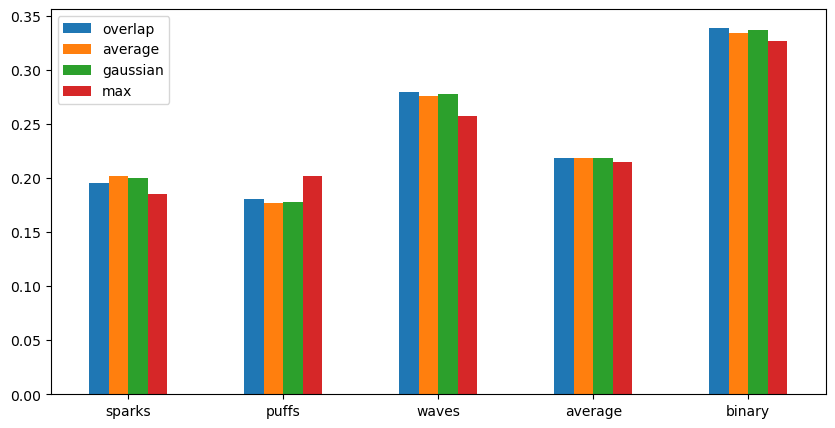

In [21]:
df_barplot.plot.bar(rot=0, figsize=(10, 5))

### Instance-based metrics

In [ ]:
# sum events over all samples
preds_cat = ['tot', 'tp', 'ignored', 'unlabeled'] + ca_release_events
ys_cat = ['tot', 'tp', 'undetected'] + ca_release_events

In [ ]:
from metrics_tools import get_score_matrix, get_matches_summary

# initialize dicts that will contain the results
matched_preds_ids = {i: {} for i in inference_types}
matched_ys_ids = {i: {} for i in inference_types}

for i in inference_types:
    matched_preds_ids[i]['sum'] = {}
    matched_ys_ids[i]['sum'] = {}
    for ca_event in ca_release_events:
        matched_preds_ids[i]['sum'][ca_event] = {cat: 0 for cat in preds_cat if cat != ca_event}
        matched_ys_ids[i]['sum'][ca_event] = {cat: 0 for cat in ys_cat if cat != ca_event}

for sample_id in sample_ids:
    logger.info(f"Processing sample {sample_id}...")

    # get ignore mask for this sample
    ignore_mask = ys[sample_id] == 4

    # compute pairwise scores between annotated and predicted ROIs
    # (for each inference type)
    for i in inference_types:
        logger.info(f"\tInference type {i}...")
        iomin_scores = get_score_matrix(
            ys_instances=ys_instances[sample_id],
            preds_instances=preds_instances[sample_id][i],
            ignore_mask=None,
            score="iomin",
        )

        # get ids of matched ROIs
        matched_ys_ids[i][sample_id], matched_preds_ids[i][sample_id] = get_matches_summary(
            ys_instances=ys_instances[sample_id],
            preds_instances=preds_instances[sample_id][i],
            scores=iomin_scores,
            t=iomin_t,
            ignore_mask=ignore_mask,
        )

        # count number of categorized events that are necessary for the metrics
        for ca_event in ca_release_events:
            for cat in matched_ys_ids[i][sample_id][ca_event].keys():
                matched_ys_ids[i]['sum'][ca_event][cat] += len(matched_ys_ids[i][sample_id][ca_event][cat])
            
            for cat in matched_preds_ids[i][sample_id][ca_event].keys():
                matched_preds_ids[i]['sum'][ca_event][cat] += len(matched_preds_ids[i][sample_id][ca_event][cat])   

[17:03:22] [  INFO  ] [  __main__  ] < 15 > -- Processing sample 05...
[17:03:22] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type overlap...
[17:03:37] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type average...
[17:03:53] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type gaussian...
[17:04:08] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type max...
[17:04:23] [  INFO  ] [  __main__  ] < 15 > -- Processing sample 10...
[17:04:23] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type overlap...
[17:04:29] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type average...
[17:04:34] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type gaussian...
[17:04:40] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type max...
[17:04:45] [  INFO  ] [  __main__  ] < 15 > -- Processing sample 15...
[17:04:45] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type overlap...
[17:04:54] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type average...
[17:05:03] [  INFO  ] [  __main__  ] < 23 > -- 	Infer

In [ ]:
from metrics_tools import get_metrics_from_summary

# get dict that only contains sum over all samples
tot_preds = {i: {ca_class: matched_preds_ids[i]['sum'][ca_class]['tot']
             for ca_class in ca_release_events} for i in inference_types}
tp_preds = {i: {ca_class: matched_preds_ids[i]['sum'][ca_class]['tp']
            for ca_class in ca_release_events} for i in inference_types}
ignored_preds = {i: {ca_class: matched_preds_ids[i]['sum'][ca_class]['ignored']
                 for ca_class in ca_release_events} for i in inference_types}
unlabeled_preds = {i: {ca_class: matched_preds_ids[i]['sum'][ca_class]['unlabeled']
                   for ca_class in ca_release_events} for i in inference_types}
tot_ys = {i: {ca_class: matched_ys_ids[i]['sum'][ca_class]['tot']
          for ca_class in ca_release_events} for i in inference_types}
tp_ys = {i: {ca_class: matched_ys_ids[i]['sum'][ca_class]['tp']
         for ca_class in ca_release_events} for i in inference_types}
undetected_ys = {i: {ca_class: matched_ys_ids[i]['sum'][ca_class]['undetected']
                 for ca_class in ca_release_events} for i in inference_types}


metrics_all = {i: {} for i in inference_types}

# get other metrics (precision, recall, % correctly classified, % detected)
for i in inference_types:
    metrics_all[i] = get_metrics_from_summary(tot_preds=tot_preds[i],
                                            tp_preds=tp_preds[i],
                                            ignored_preds=ignored_preds[i],
                                            unlabeled_preds=unlabeled_preds[i],
                                            tot_ys=tot_ys[i],
                                            tp_ys=tp_ys[i],
                                            undetected_ys=undetected_ys[i])

In [ ]:
# Compute same metrics but as % instad of absolute numbers
matched_preds_percent = {i: {ca_event: {} for ca_event in ca_release_events} for i in inference_types}
matched_ys_percent = {i: {ca_event: {} for ca_event in ca_release_events} for i in inference_types}

for i in inference_types:
    for ca_event in ca_release_events:
        for cat in matched_preds_ids[i]['sum'][ca_event].keys():
            if cat != 'tot':
                matched_preds_percent[i][ca_event][cat] = (matched_preds_ids[i]['sum'][ca_event][cat] 
                                                        / matched_preds_ids[i]['sum'][ca_event]['tot'] * 100)
            
        for cat in matched_ys_ids[i]['sum'][ca_event].keys():
            if cat != 'tot':
                matched_ys_percent[i][ca_event][cat] = (matched_ys_ids[i]['sum'][ca_event][cat] 
                                                        / matched_ys_ids[i]['sum'][ca_event]['tot'] * 100)

In [ ]:
def get_df_summary_detected_events(inf):
    # create dataframe where columns are event types and index are metrics (tp, ignored, etc.)
    df1 = pd.DataFrame(matched_preds_ids[inf]['sum'])
    df1.loc['sparks']['sparks'] = df1.loc['tp']['sparks']
    df1.loc['puffs']['puffs'] = df1.loc['tp']['puffs']
    df1.loc['waves']['waves'] = df1.loc['tp']['waves']

    df2 = pd.DataFrame(matched_preds_percent[inf])
    df2.loc['sparks']['sparks'] = df2.loc['tp']['sparks']
    df2.loc['puffs']['puffs'] = df2.loc['tp']['puffs']
    df2.loc['waves']['waves'] = df2.loc['tp']['waves']
    df2 = df2.rename(columns={
        'sparks': '% sparks',
        'puffs': '% puffs',
        'waves': '% waves',})

    df = pd.concat([df1, df2], axis=1)
    df = df.drop(['tp'])

    df = df.rename(index={
        'tot': 'tot detected',
        'sparks': 'matched with labeled sparks',
        'puffs': 'matched with labeled puffs',
        'waves': 'matched with labeled waves',})
    
    convert_dict = {'sparks': int,
                    'puffs': int,
                    'waves': int,
                    }

    df = df.astype(convert_dict)
    #df = df.style.set_caption(f"Summary of detected events ({inf} inference)")
    df = df.style.format(precision=2)
    return df

def get_df_summary_labeled_events(inf):
    # create dataframe where columns are event types and index are metrics (tp, ignored, etc.)
    df1 = pd.DataFrame(matched_ys_ids[inf]['sum'])
    df1.loc['sparks']['sparks'] = df1.loc['tp']['sparks']
    df1.loc['puffs']['puffs'] = df1.loc['tp']['puffs']
    df1.loc['waves']['waves'] = df1.loc['tp']['waves']

    df2 = pd.DataFrame(matched_ys_percent[inf])
    df2.loc['sparks']['sparks'] = df2.loc['tp']['sparks']
    df2.loc['puffs']['puffs'] = df2.loc['tp']['puffs']
    df2.loc['waves']['waves'] = df2.loc['tp']['waves']
    df2 = df2.rename(columns={
        'sparks': '% sparks',
        'puffs': '% puffs',
        'waves': '% waves',})

    df = pd.concat([df1, df2], axis=1)
    df = df.drop(['tp'])

    df = df.rename(index={
        'tot': 'tot labeled',
        'sparks': 'matched with detected sparks',
        'puffs': 'matched with detected puffs',
        'waves': 'matched with detected waves',})
    
    convert_dict = {'sparks': int,
                    'puffs': int,
                    'waves': int,
                    }

    df = df.astype(convert_dict)
    #df = df.style.set_caption(f"Summary of labeled events ({inf} inference)")
    df = df.style.format(precision=2)
    return df


In [ ]:
print("Summary of detected events")
for i in inference_types:    
    print(f"{i} inference")
    display(get_df_summary_detected_events(i))

print("Summary of labeled events")
for i in inference_types:    
    print(f"{i}")
    display(get_df_summary_labeled_events(i))

Summary of detected events
overlap inference


,sparks,puffs,waves,% sparks,% puffs,% waves
tot detected,398,138,4,nan,nan,nan
ignored,16,7,0,4.02,5.07,0.00
unlabeled,128,57,0,32.16,41.30,0.00
matched with labeled puffs,69,49,0,17.34,35.51,0.00
matched with labeled waves,36,12,4,9.05,8.70,100.00
matched with labeled sparks,150,18,0,37.69,13.04,0.00


average inference


,sparks,puffs,waves,% sparks,% puffs,% waves
tot detected,392,138,4,nan,nan,nan
ignored,15,6,0,3.83,4.35,0.00
unlabeled,125,55,0,31.89,39.86,0.00
matched with labeled puffs,70,46,0,17.86,33.33,0.00
matched with labeled waves,33,15,4,8.42,10.87,100.00
matched with labeled sparks,150,20,0,38.27,14.49,0.00


gaussian inference


,sparks,puffs,waves,% sparks,% puffs,% waves
tot detected,406,143,4,nan,nan,nan
ignored,20,6,0,4.93,4.20,0.00
unlabeled,133,60,0,32.76,41.96,0.00
matched with labeled puffs,70,47,0,17.24,32.87,0.00
matched with labeled waves,34,14,4,8.37,9.79,100.00
matched with labeled sparks,149,20,0,36.70,13.99,0.00


max inference


,sparks,puffs,waves,% sparks,% puffs,% waves
tot detected,427,156,4,nan,nan,nan
ignored,12,5,0,2.81,3.21,0.00
unlabeled,152,62,0,35.60,39.74,0.00
matched with labeled puffs,78,51,0,18.27,32.69,0.00
matched with labeled waves,34,19,4,7.96,12.18,100.00
matched with labeled sparks,152,23,0,35.60,14.74,0.00


Summary of labeled events
overlap


,sparks,puffs,waves,% sparks,% puffs,% waves
tot labeled,265,74,7,nan,nan,nan
undetected,92,19,1,34.72,25.68,14.29
matched with detected puffs,24,41,5,9.06,55.41,71.43
matched with detected waves,0,0,4,0.00,0.00,57.14
matched with detected sparks,152,39,6,57.36,52.70,85.71


average


,sparks,puffs,waves,% sparks,% puffs,% waves
tot labeled,265,74,7,nan,nan,nan
undetected,92,19,0,34.72,25.68,0.00
matched with detected puffs,26,39,5,9.81,52.70,71.43
matched with detected waves,0,0,4,0.00,0.00,57.14
matched with detected sparks,152,40,6,57.36,54.05,85.71


gaussian


,sparks,puffs,waves,% sparks,% puffs,% waves
tot labeled,265,74,7,nan,nan,nan
undetected,94,19,0,35.47,25.68,0.00
matched with detected puffs,26,40,5,9.81,54.05,71.43
matched with detected waves,0,0,4,0.00,0.00,57.14
matched with detected sparks,151,40,6,56.98,54.05,85.71


max


,sparks,puffs,waves,% sparks,% puffs,% waves
tot labeled,265,74,7,nan,nan,nan
undetected,91,19,0,34.34,25.68,0.00
matched with detected puffs,29,40,5,10.94,54.05,71.43
matched with detected waves,0,0,4,0.00,0.00,57.14
matched with detected sparks,153,42,6,57.74,56.76,85.71


In [ ]:
pd.set_option('display.precision', 2)

def get_df_metrics(inf):
    df_data = {}

    for event_type in ['sparks', 'puffs', 'waves', 'average']:
        df_data[event_type] = {}
        for type_metric, val in metrics_all[inf].items():      
            if type_metric.startswith(event_type):
                df_data[event_type][type_metric.replace(event_type+"/", "")] = val

    # get dataframe where index are event types and columns are metrics
    df = pd.DataFrame(df_data).T
    # df = df.style.set_caption(f"Metrics using {inf} inference")
    df = df.style.format(precision=2)
    return df

In [ ]:
for i in inference_types:
    print(f"Metrics using {i} inference")
    display(get_df_metrics(i))

Metrics using overlap inference


,precision,recall,correctly_classified,detected
sparks,0.39,0.57,0.59,0.65
puffs,0.37,0.55,0.66,0.74
waves,1.00,0.57,1.00,0.86
average,0.59,0.57,0.75,0.75


Metrics using average inference


,precision,recall,correctly_classified,detected
sparks,0.40,0.57,0.60,0.65
puffs,0.35,0.53,0.60,0.74
waves,1.00,0.57,1.00,1.00
average,0.58,0.56,0.73,0.80


Metrics using gaussian inference


,precision,recall,correctly_classified,detected
sparks,0.39,0.57,0.59,0.65
puffs,0.34,0.54,0.61,0.74
waves,1.00,0.57,1.00,1.00
average,0.58,0.56,0.73,0.80


Metrics using max inference


,precision,recall,correctly_classified,detected
sparks,0.37,0.58,0.58,0.66
puffs,0.34,0.54,0.57,0.74
waves,1.00,0.57,1.00,1.00
average,0.57,0.56,0.72,0.80


## Visualize other properties of data...

### Plot histograms of raw predictions

In [31]:
from matplotlib import pyplot as plt

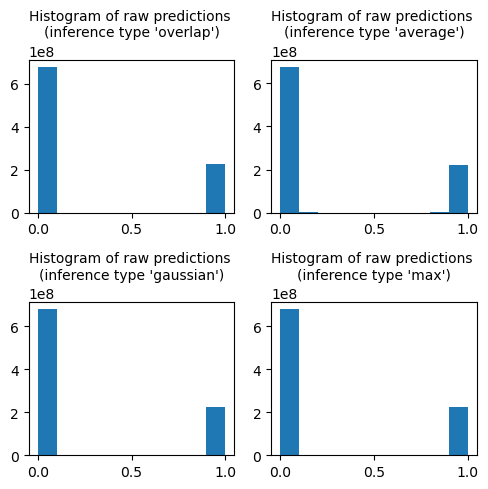

In [38]:
fig, axs = plt.subplots(2,2, figsize=(5, 5))

for i, ax in zip(inference_types, axs.flatten()):
    # concatenate raw predictions
    raw_preds_concat = [preds[sample_id][i] for sample_id in sample_ids]
    raw_preds_concat = np.concatenate(raw_preds_concat, axis=1)
    
    ax.hist(raw_preds_concat.flatten(), bins=10)
    ax.set_title(f"Histogram of raw predictions \n(inference type '{i}')", fontsize = 10.0)

fig.tight_layout()

### Compute signal-to-noise (SNR) of testing dataset movies

In [41]:
snr = {}
for sample_id in sample_ids:
    # get sample
    x = xs[sample_id]
    # get annotations
    y = ys[sample_id]
    # remove ignored regions from annotations
    y[y==4] = 0
    # get binary annotations
    y = y != 0

    # get masked movie
    masked_movie = x * y

    # compute signal-to-noise ratio on masked movie
    snr[sample_id] = np.mean(masked_movie) / np.std(masked_movie)


Text(0, 0.5, 'SNR')

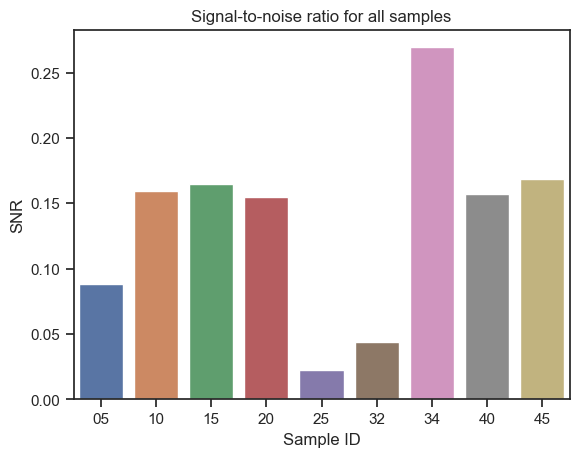

In [45]:
# plot snr for all samples using seaborn
import seaborn as sns

sns.set_theme(style="ticks")
ax = sns.barplot(x=list(snr.keys()), y=list(snr.values()))
ax.set_title("Signal-to-noise ratio for all samples")
ax.set_xlabel("Sample ID")
ax.set_ylabel("SNR")

In [46]:
# visualize snr with respect to samples given to experts for inter-rater agreement
slice_to_movie_id = {'01': '15',
                     '02': '20',
                     '03': '34',
                     '04': '05',
                     '05': '10',
                     '06': '25',
                     '07': '32',
                     '08': '34',
                     '09': '40',
                     '10': '45'}

movie_id_to_slice = {v: k for k, v in slice_to_movie_id.items()}
slice_ids = list(slice_to_movie_id.keys())

# get snr for samples given to experts
snr_experts = {slice_id: snr[slice_to_movie_id[slice_id]] for slice_id in slice_ids}

In [50]:
# print snr_experts as table
df_snr_experts = pd.DataFrame.from_dict(snr_experts, orient='index', columns=['snr'])
df_snr_experts = df_snr_experts.rename_axis('slice_id')
df_snr_experts = df_snr_experts.style.format(precision=2)
df_snr_experts


,snr
slice_id,
01,0.16
02,0.15
03,0.27
04,0.09
05,0.16
06,0.02
07,0.04
08,0.27
09,0.16


Text(0, 0.5, 'SNR')

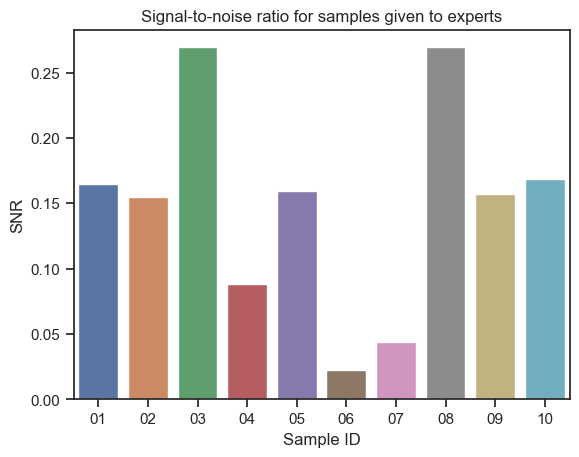

In [47]:
# visualize snr for samples given to experts
ax = sns.barplot(x=list(snr_experts.keys()), y=list(snr_experts.values()))
ax.set_title("Signal-to-noise ratio for samples given to experts")
ax.set_xlabel("Sample ID")
ax.set_ylabel("SNR")

Text(0, 0.5, "Fleiss' Kappa")

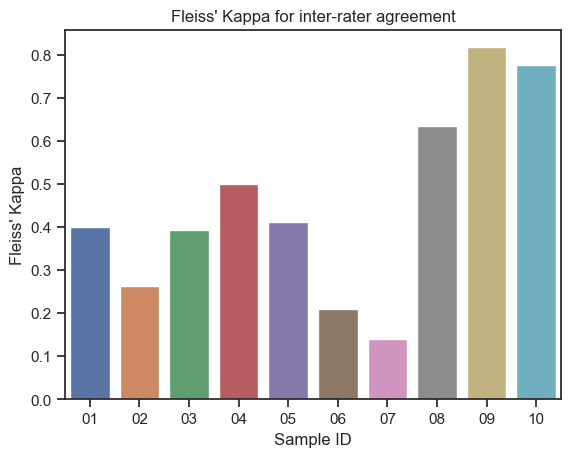

In [48]:
# Fleiss' Kappa for inter-rater agreement
fleiss_kappas = {'01': 0.4,
                 '02': 0.263,
                 '03': 0.393,
                 '04': 0.499,
                 '05': 0.411,
                 '06': 0.210,
                 '07': 0.140,
                 '08': 0.635,
                 '09': 0.817,
                 '10': 0.776}

# visualize fleiss kappas as barplot
ax = sns.barplot(x=list(fleiss_kappas.keys()), y=list(fleiss_kappas.values()))
ax.set_title("Fleiss' Kappa for inter-rater agreement")
ax.set_xlabel("Sample ID")
ax.set_ylabel("Fleiss' Kappa")

Pearsons correlation: 0.487


Text(0, 0.5, "Fleiss' Kappa")

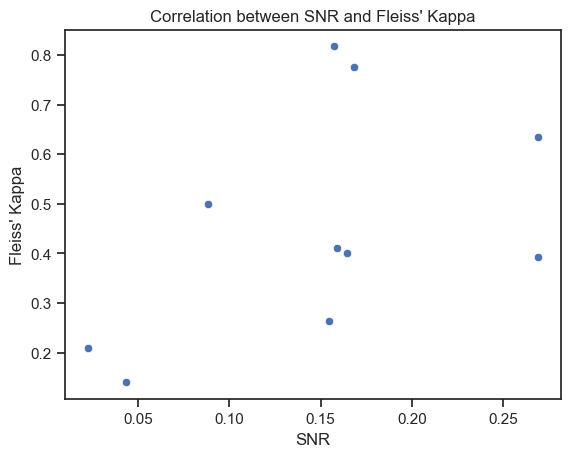

In [49]:
# check if there is a correlation between snr and fleiss kappas
from scipy.stats import pearsonr

snr_experts_list = list(snr_experts.values())
fleiss_kappas_list = list(fleiss_kappas.values())

corr, _ = pearsonr(snr_experts_list, fleiss_kappas_list)
print('Pearsons correlation: %.3f' % corr)

# visualize snr and fleiss kappas as scatterplot
ax = sns.scatterplot(x=snr_experts_list, y=fleiss_kappas_list)
ax.set_title("Correlation between SNR and Fleiss' Kappa")
ax.set_xlabel("SNR")
ax.set_ylabel("Fleiss' Kappa")

### code to try and visualize different types of inference

In [ ]:
# ## DEBUG ###

# test_dataset = SparkDataset(
#         base_path=dataset_path,
#         sample_ids=['34'],
#         testing=testing,
#         smoothing=c.get("dataset", "data_smoothing"),
#         step=c.getint("testing", "data_step"),
#         #step=2,
#         duration=c.getint("testing", "data_duration"),
#         remove_background=c.get("dataset", "remove_background"),
#         temporal_reduction=c.getboolean(
#             "network", "temporal_reduction", fallback=False
#         ),
#         num_channels=c.getint("network", "num_channels", fallback=1),,
#         normalize_video=c.get("dataset", "norm_video"),
#         only_sparks=c.getboolean("dataset", "only_sparks", fallback=False),
#         sparks_type=c.get("dataset", "sparks_type"),
#         ignore_frames=c.getint("training", "ignore_frames_loss"),
#         ignore_index=4,
#         gt_available=True,
#         inference=inference,
#     )

# testing_dataloader = torch.utils.data.DataLoader(
#     test_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=True,
# )

# from training_inference_tools import do_inference

# test_dataset.inference = 'overlap'
# pred_overlap = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )


# test_dataset.inference = 'average'
# pred_average = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )

# test_dataset.inference = 'max'
# pred_max = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )

# test_dataset.inference = 'gaussian'
# pred_gaussian = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )

# pred_overlap.shape, pred_average.shape, pred_max.shape, pred_gaussian.shape
# empty_vertical = np.ones((pred_overlap.shape[0],
#                           pred_overlap.shape[1],
#                           pred_overlap.shape[2],
#                           10))*0.5

# empty_horizontal = np.ones((pred_overlap.shape[0],
#                             pred_overlap.shape[1],
#                             10,
#                             2*pred_overlap.shape[3]+10))*0.5
# # stack the four predictions togheter in a squared grid

# stack1 = np.concatenate((pred_overlap, empty_vertical, pred_average), axis=3)
# stack2 = np.concatenate((pred_max, empty_vertical, pred_gaussian), axis=3)

# stack_all = np.concatenate((stack1, empty_horizontal, stack2), axis=2)
# import napari
# viewer = napari.Viewer()
# viewer.theme = 'dark'

# viewer.add_image(stack_all[0], 
#                  name='background',
#                     #colormap='white',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

# viewer.add_image(stack_all[1],
#                     name='sparks',
#                     colormap='green',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

# viewer.add_image(stack_all[2],
#                     name='waves',
#                     colormap='yellow',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

# viewer.add_image(stack_all[3],
#                     name='puffs',
#                     colormap='red',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )